














































# **Importation of Required Library and utilities**

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import shutil

from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from pathlib import Path

data_dir = '/content/drive/MyDrive/Plant_DiseaseV2'
destpath_train = '/content/drive/MyDrive/Plant_DiseaseV2'
destpath = '/content/drive/MyDrive/Plant_DiseaseV2'

# **Importing from Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Splitting the dataset**

In [ ]:
def create_reduced_dataset(original_dataset_path, new_dataset_path, desired_images_per_class):

    original_dataset_path = os.path.abspath(original_dataset_path)
    new_dataset_path = os.path.abspath(new_dataset_path)


    if not os.path.exists(new_dataset_path):
        os.makedirs(new_dataset_path)


    classes = os.listdir(original_dataset_path)

    for class_name in classes:
        class_path = os.path.join(original_dataset_path, class_name)


        new_class_path = os.path.join(new_dataset_path, class_name)
        os.makedirs(new_class_path)

        images = os.listdir(class_path)

        desired_images = desired_images_per_class.get(class_name, 0)

        num_images_to_copy = min(len(images), desired_images)

        selected_images = random.sample(images, num_images_to_copy) if len(images) > desired_images else images

        for image_name in selected_images:
            original_image_path = os.path.join(class_path, image_name)
            new_image_path = os.path.join(new_class_path, image_name)
            shutil.move(original_image_path, new_image_path)

        print(f"Class: {class_name}, Desired Images: {desired_images}, Actual Images: {num_images_to_copy}")

if __name__ == "__main__":
    # Replace 'original_dataset_path' and 'new_dataset_path' with your actual paths
    original_dataset_path = '/content/drive/MyDrive/Plant_DiseaseV2'
    new_dataset_path = '/content/drive/MyDrive/Strata-final-disease'

    # Specify the desired number of images for each class
    desired_images_per_class = {
        'Blacking': 110,
        'Drying': 125,
        'Healthy': 652,
        'Leaf-Miner':197,
        'Leaf-Spots': 175,
        'Powdery-Mildew': 125,
        'Yellowing': 159
    }

    create_reduced_dataset(original_dataset_path, new_dataset_path, desired_images_per_class)

Class: Yellowing, Desired Images: 159, Actual Images: 159
Class: Powdery-Mildew, Desired Images: 125, Actual Images: 125
Class: Leaf-Spots, Desired Images: 175, Actual Images: 175
Class: Leaf-Miner, Desired Images: 197, Actual Images: 197
Class: Drying, Desired Images: 125, Actual Images: 125
Class: Healthy, Desired Images: 652, Actual Images: 652
Class: Blacking, Desired Images: 110, Actual Images: 110


In [ ]:
import os

def count_files_in_folder(folder_path):
    # Make sure the path is absolute
    folder_path = os.path.abspath(folder_path)

    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"The folder '{folder_path}' does not exist.")
        return

    # Initialize the count of files
    file_count = 0

    # Iterate through the folder and its subfolders
    for root, dirs, files in os.walk(folder_path):
        # Count files in the current folder
        file_count += len(files)

    # Print the total count of files
    print(f"Number of files in the folder '{folder_path}' and its subfolders: {file_count}")

if __name__ == "__main__":
    # Replace 'folder_path' with the actual path to your folder
    folder_path = '/content/drive/MyDrive/Strata-final-disease'

    count_files_in_folder(folder_path)

Number of files in the folder '/content/drive/MyDrive/Strata-final-disease' and its subfolders: 1543


In [ ]:
batch_size = 32
img_height = 256
img_width = 256
Image_size = 256
Batch_size = 32
Channels = 3

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1337719298245,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4560 files belonging to 7 classes.
Using 3951 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1337719298245,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4560 files belonging to 7 classes.
Using 609 files for validation.


# **Class Names Checking**

In [ ]:
class_names = train_ds.class_names
print(class_names)


['Blacking', 'Drying', 'Healthy', 'Leaf-Miner', 'Leaf-Spots', 'Powdery-Mildew', 'Yellowing']


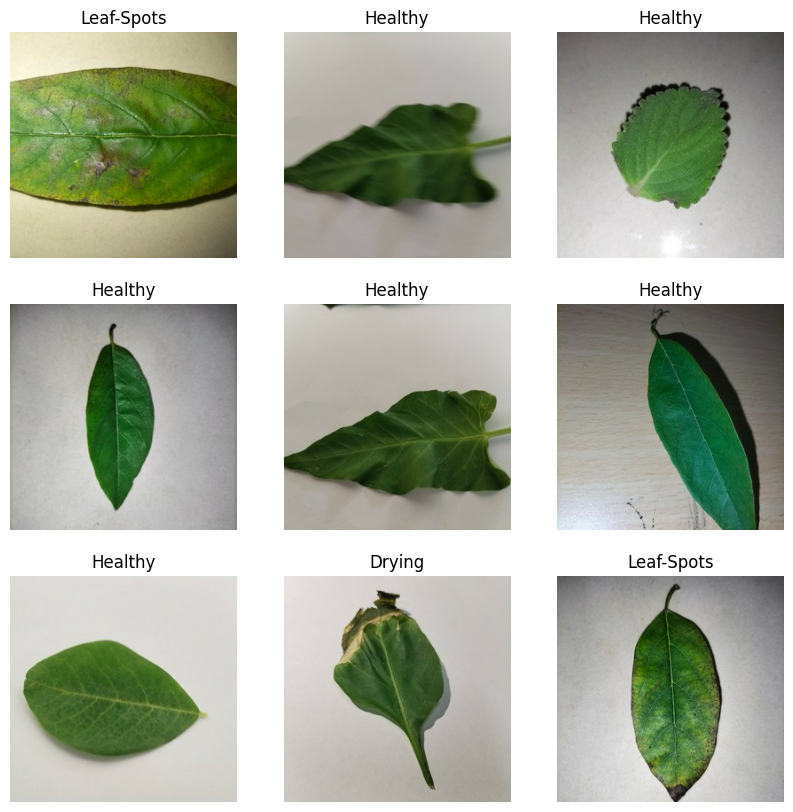

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Model Set up and Data Preparation

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 7

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(126, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
img_data_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = img_data_gen_test.flow_from_directory(data_dir, batch_size=batch_size,
                                                  class_mode='categorical')

Found 4560 images belonging to 7 classes.


In [ ]:
dataset_train=tf.keras.preprocessing.image_dataset_from_directory(
    destpath_train,
    shuffle=False,
    image_size=(Image_size, Image_size),
    batch_size=(Batch_size))
dataset_test=tf.keras.preprocessing.image_dataset_from_directory(
    destpath,
    shuffle=False,
    image_size=(Image_size, Image_size),
    batch_size=(Batch_size))

Found 4560 files belonging to 7 classes.
Found 4560 files belonging to 7 classes.


In [ ]:
class_names=dataset_train.class_names
n_classes=len(class_names)
class_names

['Blacking',
 'Drying',
 'Healthy',
 'Leaf-Miner',
 'Leaf-Spots',
 'Powdery-Mildew',
 'Yellowing']

In [ ]:
for image_batch, label_batch in dataset_train.take(3):
    print(image_batch.shape)
    print(label_batch.shape)


(32, 256, 256, 3)
(32,)
(32, 256, 256, 3)
(32,)
(32, 256, 256, 3)
(32,)


In [ ]:
img_data_gen = ImageDataGenerator(rescale=1./255, rotation_range=90, horizontal_flip=True, vertical_flip=True,
                                 shear_range=0.2, validation_split=0.2)

train_data_gen = img_data_gen.flow_from_directory(destpath_train, batch_size=Batch_size, subset='training',
                                                  class_mode='categorical', shuffle=True)

val_data_gen = img_data_gen.flow_from_directory(destpath_train, batch_size=Batch_size, subset='validation',
                                                  class_mode='categorical', shuffle=True)

Found 3650 images belonging to 7 classes.
Found 910 images belonging to 7 classes.


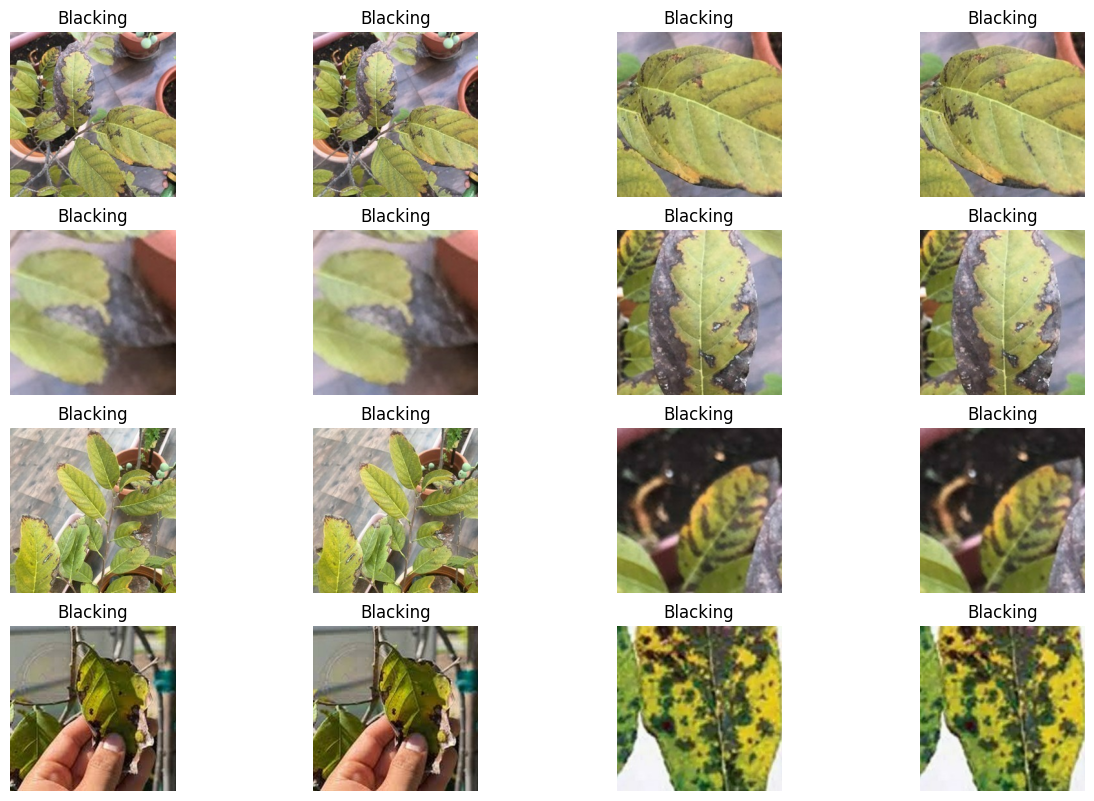

In [ ]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset_train.take(1):
    for i in range(min(16, len(image_batch))):
        ax=plt.subplot(6,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# **Model**

In [ ]:
from tensorflow.keras.applications import DenseNet169
from keras import regularizers
from tensorflow.keras.regularizers import l1_l2

In [ ]:
EPOCHS=25

In [ ]:
# Function for building the model
def model_building(model_name, INPUT_SHAPE=[Image_size, Image_size, Channels]):
    print('Model Initialization started')
    base_model = model_name(include_top=False, weights='imagenet', input_shape=[Image_size, Image_size, Channels])

    for layers in base_model.layers:
        layers.trainable = False
    print('Model Initialization finished')

    #model creation
    print('Model creation started')
    inp_model = base_model.output

    x = GlobalAveragePooling2D()(inp_model)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(n_classes, activation = 'sigmoid')(x)

    model = Model(inputs = base_model.input, outputs = x)


    #model compilation
    optimizer_to_use=Adam(learning_rate=0.002)
    model.compile(optimizer = optimizer_to_use, metrics=['accuracy'], loss = 'categorical_crossentropy')
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=1, min_lr=1e-3)
    history = model.fit(train_data_gen, validation_data=val_data_gen,callbacks=[checkpoint, annealer],
                        max_queue_size=20,
                       epochs=EPOCHS)

    # Plotting the training history
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

    print('Model Building Finished')
    model.save('model.keras')
    print('Model was saved')

    return model, history

Model Initialization started
Model Initialization finished
Model creation started
Epoch 1/25
115/115 [==============================] - ETA: 0s - loss: 0.3619 - accuracy: 0.8789
Epoch 1: val_loss improved from inf to 0.28593, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


115/115 [==============================] - 1361s 12s/step - loss: 0.3619 - accuracy: 0.8789 - val_loss: 0.2859 - val_accuracy: 0.8956 - lr: 0.0020
Epoch 2/25
115/115 [==============================] - ETA: 0s - loss: 0.0678 - accuracy: 0.9836
Epoch 2: val_loss improved from 0.28593 to 0.20707, saving model to model.h5
115/115 [==============================] - 112s 975ms/step - loss: 0.0678 - accuracy: 0.9836 - val_loss: 0.2071 - val_accuracy: 0.9209 - lr: 0.0020
Epoch 3/25
115/115 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9866
Epoch 3: val_loss did not improve from 0.20707
115/115 [==============================] - 112s 969ms/step - loss: 0.0472 - accuracy: 0.9866 - val_loss: 0.2260 - val_accuracy: 0.9088 - lr: 0.0020
Epoch 4/25
115/115 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9910
Epoch 4: val_loss did not improve from 0.20707
115/115 [==============================] - 111s 970ms/step - loss: 0.0351 - accuracy: 0.9910 - val

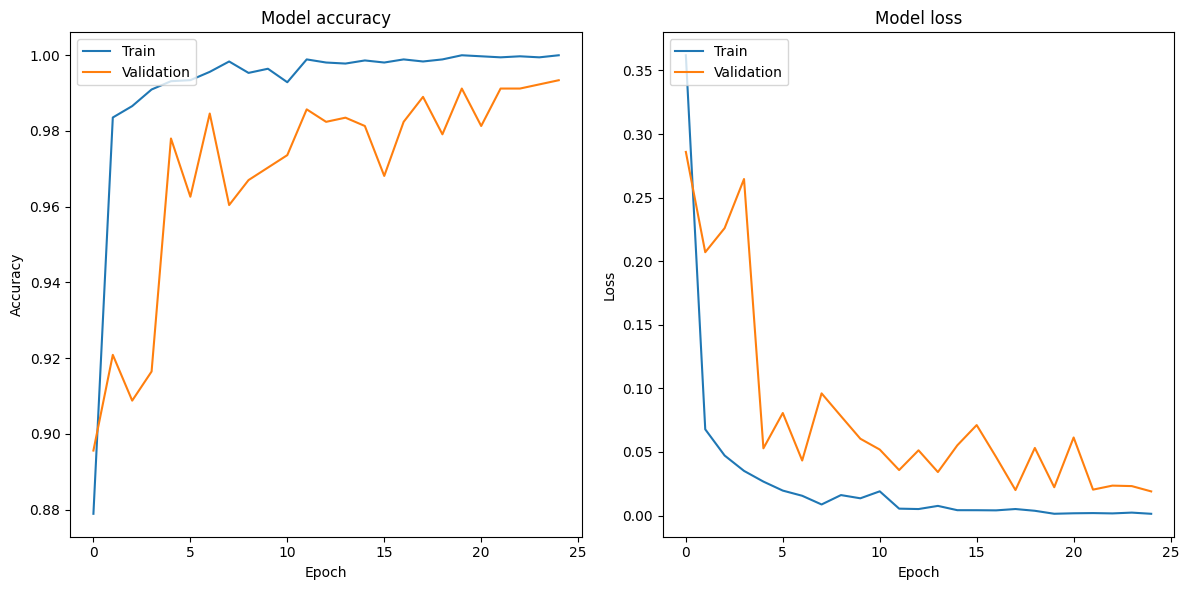

Model Building Finished
Model was saved


In [ ]:
dn169_history = model_building(DenseNet169)

In [ ]:
model.summary()

ValueError: ignored

In [ ]:
loaded_model = tf.keras.models.load_model('model.h5')

# **Testing**

In [ ]:
from tensorflow.keras.models import load_model

# Load your pre-trained model
model = load_model('/content/model.h5')

In [ ]:
dn169_scores= model.evaluate(test_data_gen, verbose=2)

143/143 - 38s - loss: 0.0034 - accuracy: 0.9989 - 38s/epoch - 262ms/step


In [ ]:
print("The test accuracy is "+str(round(dn169_scores[1]*100,2))+'%')

The test accuracy is 99.89%


In [ ]:
def predict(model, img):
    image_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(image_array,0)
    img_array=img_array/255
    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
def predict(model, img):
    # Assuming 'img' is already a NumPy array or a TensorFlow tensor
    img_array = tf.convert_to_tensor(img)  # Convert to a TensorFlow tensor
    img_array = tf.image.resize(img_array, (img_height, img_width))  # Resize the image to match the model's input size
    img_array = img_array / 255.0  # Normalize the image (if necessary)

    # Reshape the image to match the model's input shape
    img_array = tf.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence


In [ ]:
# Shuffle the test dataset
dataset_test_shuffled = dataset_test.shuffle(buffer_size=len(dataset_test))

plt.figure(figsize=(24, 24))

# Iterate over the shuffled test dataset
for images, labels in dataset_test_shuffled.take(9):
    for i in range(10):
        ax = plt.subplot(5, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

        # Call the modified predict function
        actual_class, predicted_class, confidence = predict(model, images[i])

        plt.title(f" Actual: {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}%")

plt.show()

NameError: ignored

# **Custom Image Detecting Part**

In [ ]:
load_model = '/content/drive/MyDrive/Plant_Disease_Detection/model.keras'

In [ ]:
pip install opencv-python

In [ ]:
model = '/content/drive/MyDrive/Plant_Disease_Detection/model.keras'

#path to the image
img_path = '/content/drive/MyDrive/Plant_Disease_Detection/Powdery-Mildew/Image00035.jpg'

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


target_size = (256, 256)
image_resized = cv2.resize(image, target_size)

image_array = tf.keras.preprocessing.image.img_to_array(image_resized)
img_array = tf.expand_dims(image_array, 0)
img_array = img_array / 255.0


predictions = model.predict(img_array)


predicted_class = class_names[np.argmax(predictions[0])]
confidence = round(100 * np.max(predictions[0]), 2)


plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}\nConfidence: {confidence}%")
plt.axis('off')
plt.show()


NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open ("model.tflite", 'wb') as f:
   f.write(tflite_model)